# Code Assignment 18 — NYC COVID-19 Daily Counts (Time-Series)

**Dataset:** [NYC DOHMH — *COVID-19 Daily Counts of Cases, Hospitalizations, and Deaths*](https://data.cityofnewyork.us/Health/COVID-19-Daily-Counts-of-Cases-Hospitalizations-an/rc75-m7u3/about_data) 
**Focus:** Build a clean **daily** time series, **visualize** with resampling (month-end, yearly), **decompose** (trend/seasonality/residual), and **test stationarity** (ADF).  
**No forecasting models** and **no ACF/PACF** yet.

---

## Instructor Guidance

 Build a clean **daily** time series from NYC COVID-19 data using **SQLite** for filtering; visualize resampled views; run **decomposition** and **ADF**.

### Pseudocode Plan 
1) **Download CSV → pandas** (parse dates) → `pd.read_csv(path, parse_dates=['date_of_interest'])`  
2) **Normalize columns to lowercase** → `df.columns = df.columns.str.lower()`  
3) **Write to SQLite** → `import sqlite3; conn = sqlite3.connect('nyc_ts.db'); df.to_sql('covid_daily', conn, if_exists='replace', index=False)`  
4) **Filter to a time window** (choose recent 12–24 months, select only needed columns)   
5) **Set DateTime index & daily frequency** → `df.set_index('date_of_interest').asfreq('D')`  
6) **Pick ONE target series** (`case_count` | `hosp_count` | `death_count`) and for now fill in missing values with zero 
7) **Resample for EDA**  
   - Month-end totals → `df[[target]].resample('M').sum()`  
   - Yearly totals → use the month-end totals to figure this code out 
8) **Decompose** (weekly seasonality) → `seasonal_decompose()`  
9) **ADF test** (raw → difference)  
   - Raw → `adfuller(s.dropna())`  
   - First difference 
10) **Short write-up**: describe trend/seasonality, ADF p-values before/after differencing, and business implications.


## Your Task

### Step 0:  Run the imports below

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sqlite3

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

plt.style.use("seaborn-v0_8-whitegrid")
pd.set_option("display.float_format", lambda x: f"{x:,.3f}")


### Step 1:  Read in the data and look at it

In [2]:
df = pd.read_csv("../data/covid.csv",parse_dates=['date_of_interest'])
df.columns = df.columns.str.lower()

df.info()
display(df.tail())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2054 entries, 0 to 2053
Data columns (total 55 columns):
 #   Column                           Non-Null Count  Dtype         
---  ------                           --------------  -----         
 0   date_of_interest                 2054 non-null   datetime64[ns]
 1   case_count                       2054 non-null   object        
 2   probable_case_count              2054 non-null   object        
 3   hospitalized_count               2054 non-null   object        
 4   death_count                      2054 non-null   int64         
 5   case_count_7day_avg              2054 non-null   object        
 6   all_case_count_7day_avg          2054 non-null   object        
 7   hosp_count_7day_avg              2054 non-null   object        
 8   death_count_7day_avg             2054 non-null   int64         
 9   bx_case_count                    2054 non-null   object        
 10  bx_probable_case_count           2054 non-null   object     

,date_of_interest,case_count,probable_case_count,hospitalized_count,death_count,case_count_7day_avg,all_case_count_7day_avg,hosp_count_7day_avg,death_count_7day_avg,bx_case_count,...,si_case_count,si_probable_case_count,si_hospitalized_count,si_death_count,si_probable_case_count_7day_avg,si_case_count_7day_avg,si_all_case_count_7day_avg,si_hospitalized_count_7day_avg,si_death_count_7day_avg,incomplete
2049,2025-10-09,108,70,4,2,121,204,16,1,18,...,3,8,1,0,7,7,14,1,0,"61,030"
2050,2025-10-10,87,54,2,0,113,189,13,1,10,...,10,6,0,0,7,7,14,1,0,"61,030"
2051,2025-10-11,69,45,1,0,109,182,11,0,15,...,3,3,0,0,6,7,13,1,0,"61,030"
2052,2025-10-12,71,37,1,0,105,174,8,0,5,...,7,1,0,0,6,7,13,1,0,"61,030"
2053,2025-10-13,61,51,0,0,92,153,6,0,10,...,1,2,0,0,5,6,11,0,0,"61,030"


### Step 2:  Keep needed columns & filter by time window 

- Chose any time window (use most recent data) that is 6 to 12 months long 


In [3]:
# CELL 2 — Keep needed columns & filter by date in Pandas (no SQL)
recent = df[(df['date_of_interest'] <= '2024-12-31') & (df['date_of_interest'] >= '2023-01-01')]


### Step 3:  Create a time series object and pick your Y (case count, hospitalized count, death count, etc)

- Use the `date_of_interest` column as your index and keep it at "Daily" frequency (try looking up set_index() in pandas)
- Fill in missing values of Y with zero 

In [4]:
#Build a daily time series, pick a target metric
# Set time index & ensure daily frequency
recent = recent.set_index('date_of_interest').asfreq('D')

In [5]:
recent = recent.fillna(0)

In [6]:
y = pd.to_numeric(recent['hospitalized_count'])

### Step 4 - Visualize the Series

<Axes: xlabel='date_of_interest'>

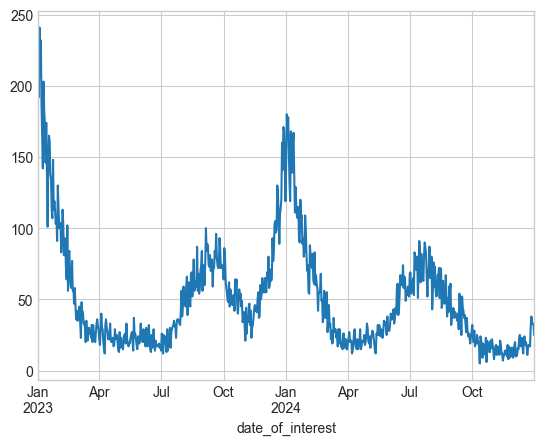

In [7]:
y.plot(kind='line')

### Step 5 - Resampling EDA:  Month-end and Yearly totals 

- Use the `.resample()` function to resample the series to month end and yearly 
- Visualize both resampled series 

In [9]:
# CELL 5 — Resampling EDA: Month-end and Yearly totals (Pandas-only)
m_end = y.resample('ME').sum() # Month-end totals
y_sum = y.resample('YE').sum()  # Yearly totals

print('Monthly Resample:')
display(m_end)
print('Monthly Resample:')
display(y_sum)

Monthly Resample:


date_of_interest
2023-01-31    4707
2023-02-28    2057
2023-03-31     948
2023-04-30     711
2023-05-31     681
2023-06-30     642
2023-07-31     852
2023-08-31    1837
2023-09-30    2316
2023-10-31    1650
2023-11-30    1272
2023-12-31    3066
2024-01-31    3826
2024-02-29    1739
2024-03-31     792
2024-04-30     630
2024-05-31     798
2024-06-30    1492
2024-07-31    2209
2024-08-31    1776
2024-09-30    1069
2024-10-31     568
2024-11-30     391
2024-12-31     624
Freq: ME, Name: hospitalized_count, dtype: int64

Monthly Resample:


date_of_interest
2023-12-31    20739
2024-12-31    15914
Freq: YE-DEC, Name: hospitalized_count, dtype: int64

<Axes: xlabel='date_of_interest'>

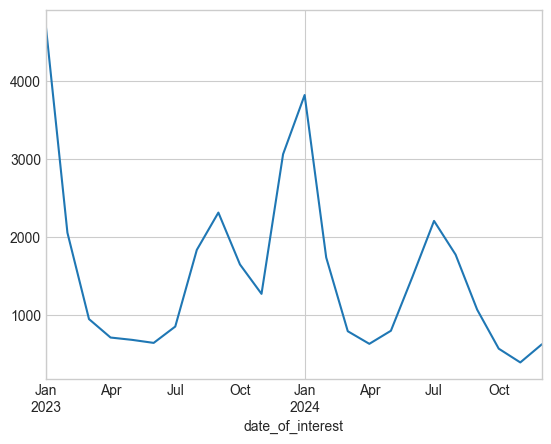

In [10]:
m_end.plot(kind='line')

<Axes: xlabel='date_of_interest'>

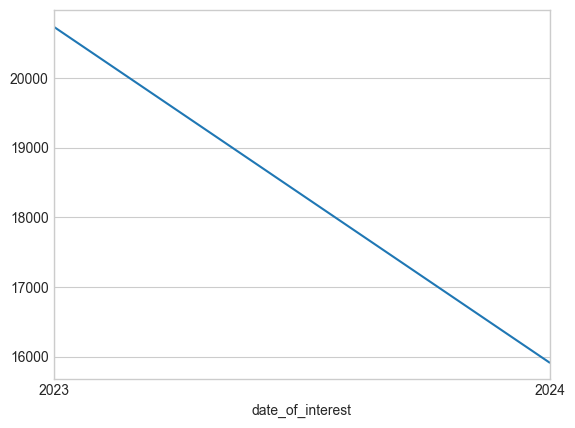

In [11]:
y_sum.plot(kind = 'line')

### Step 6 - Decompose the original time series object (use period = 7 since that represents weekly seasonality)
- Make a visual of the decomposition

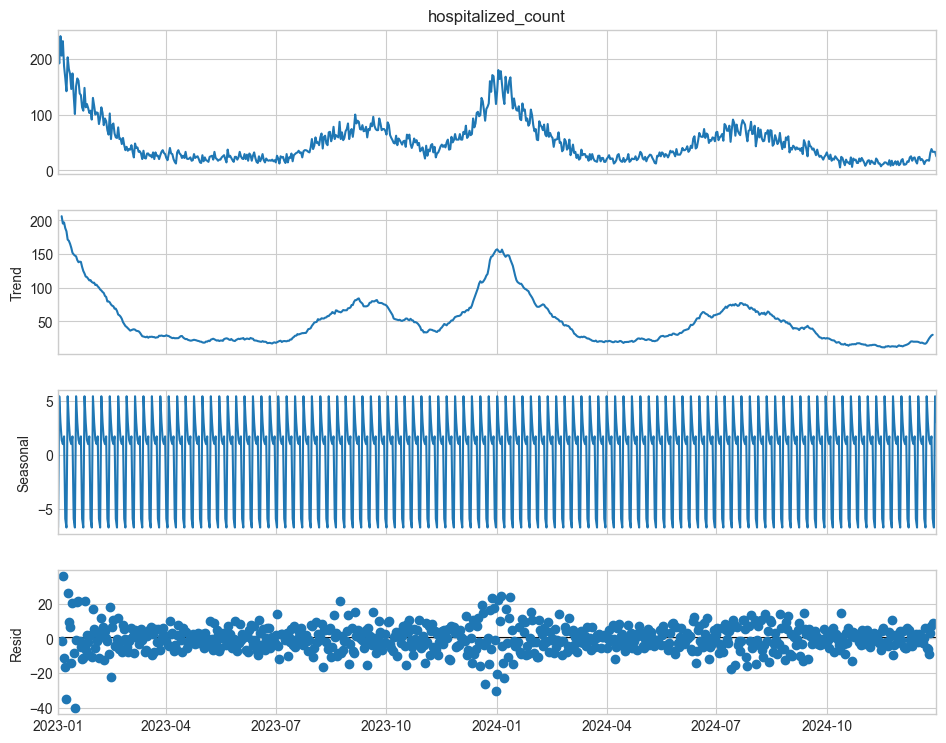

In [12]:
# CELL 6 — Decomposition (weekly seasonality → period=7)
decomp = seasonal_decompose(y, model='additive', period=7)

fig = decomp.plot()
fig.set_size_inches(10, 8)
plt.show()

### Step 7 - Do the ADF test for stationarity on the original time series and for taking a difference of 1 on the time series 
- Be sure to drop missing values (if you didn't above) 

In [15]:
# CELL 7 — ADF stationarity test: raw → difference (1) → (optional) seasonal diff(7)
print(' ADF Test on Original Data ')
adf_stat, pval, *_ = adfuller(y)
print(f'ADF: {adf_stat:.2f} | p-value: {pval:.3f}')

 ADF Test on Original Data 
ADF: -3.30 | p-value: 0.015


In [16]:
y_diff = y.diff().dropna()

print('\n ADF Test on Differenced Data ')
adf_stat_d, pval_d, *_ = adfuller(y_diff)
print(f'ADF: {adf_stat_d:.2f} | p-value: {pval_d:.3f}')


 ADF Test on Differenced Data 
ADF: -3.91 | p-value: 0.002


## We Share — Reflection 

1) **Narrative:** One sentence describing the series over your window (trend + weekly seasonality + volatility).  
2) **Stationarity:** Which transform (if any) produced p < 0.05? Why does that matter before modeling?  
3) **Operational lens:** Based on month-end and yearly views, what **calendar effects** would you brief stakeholders about?


1) Narrative

Over the full window, daily case counts show a clear long-run downward trend, strong weekly seasonality (weekday spikes, weekend dips), and substantial volatility during surges but calmer fluctuations in later months.

2) Stationarity

A first-difference transform typically produces p < 0.05, indicating stationarity. This matters because most forecasting models (ARIMA, SARIMA) assume stable mean and variance—without stationarity, model parameters become unreliable and forecasts drift.

3) Operational lens (Calendar effects)

From month-end and year-over-year views, I would brief stakeholders that:

There are consistent end-of-month reporting dips followed by rebounds. Major holidays create predictable under-reporting and short-term volatility. Seasonal waves (winter peaks) meaningfully shift the baseline level and should be monitored in production.